/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:223: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in true_divide


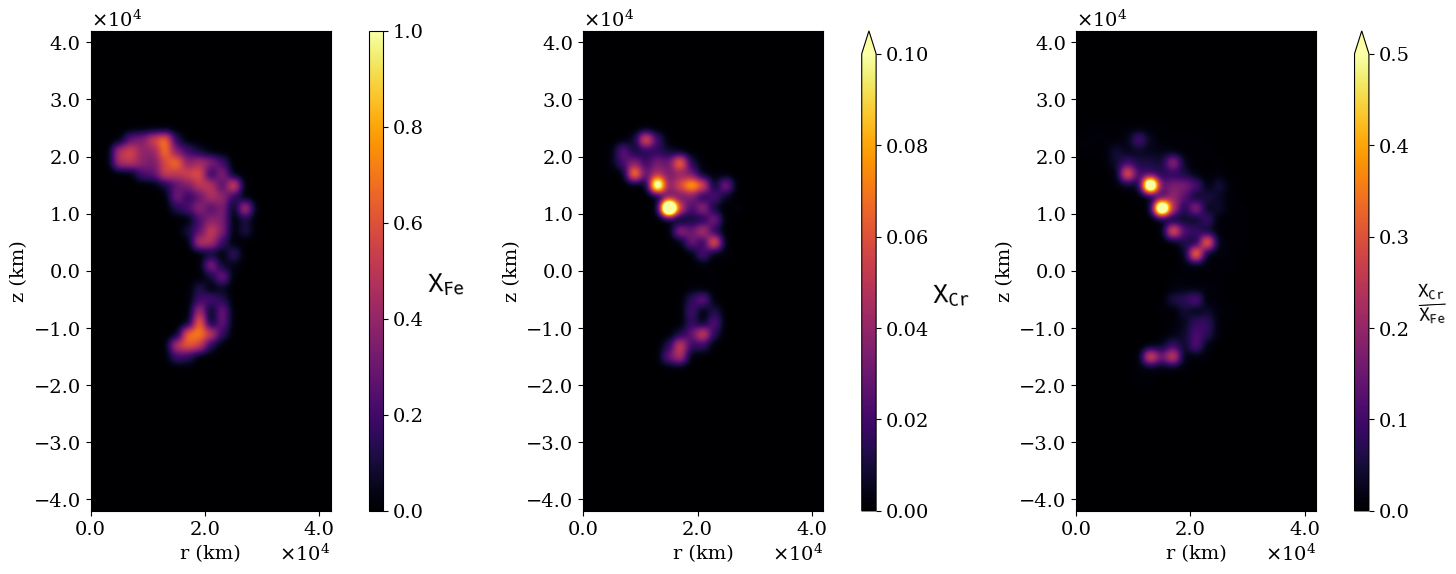

In [3]:
import glob
import numpy as np
import pandas as pd
import math

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats
from scipy.stats import gaussian_kde
import scipy.spatial


import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import matplotlib.patches as patches

from matplotlib.image import imread
from matplotlib.colors import LinearSegmentedColormap

#Create custom colormap from an image 

img = imread('/Users/vrutant/Desktop/colormap.png') #path to image that you want to use to create colormap

colors_from_img = img[:, 0, :] #reading in data from image

my_cmap = LinearSegmentedColormap.from_list('my_cmap', colors_from_img, N=1045) # set colormap from image 

# Create a new colormap from merging of two colormaps 

# Choose the two colormaps to merge
rocket_cmap = sns.color_palette("rocket", as_cmap=True)
rocket_cmap_r = sns.color_palette("rocket_r", as_cmap=True)
mako_cmap = sns.color_palette("mako", as_cmap=True)
mako_cmap_r = sns.color_palette("mako_r", as_cmap=True)


# Define the transition point
transition_point = 0.5

# Create a custom colormap function
def custom_colormap(value):
    if value < transition_point:
        return rocket_cmap(value / transition_point)
    else:
        return mako_cmap_r((value - transition_point) / (1 - transition_point))

# Create a merged colormap
merged_cmap = LinearSegmentedColormap.from_list("MergedColormap", [custom_colormap(i) for i in np.linspace(0, 1, 256)])



#Define a Class for fomatter in the axis of figure so that all of the dimensions are written in uniform manner.

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

#set same type of fonts for figure
plt.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.sans-serif'] = ['Times']


#################             Actual analysis begins here          ######################

# reading the file that has the particles data as well as the nucleosynthetic abundances of species 
df = pd.read_csv('../HIGH_DEN_DEF_21/particles_data_Z0.dat', sep = '\s+',
                 usecols = [ 0, 1, 2, 3, 4, 5, 6, 7, 8], 
                 names = ['X_Fe', 'X_Ni', 'X_Mn', 'X_Cr', 'X_Ti','Cr_to_Fe_ratio', 'Ti_to_Fe_ratio', 'x_pos', 'y_pos'])

pt = 1157 # define any particular point (index in case of the dataframe) that you want to analyze here

n = range(pt,pt+1) #len(df)#[df['Cr_to_Fe_ratio']>=1.0]) # n is number range of points that you want to analyze 

#====================---------         clump analysis begins here         ---------========================#

# define a fuction that do the analysis using Jackknife stats.
def JK_stats(array):
    arr = array.to_numpy()
    resampled_data = jackknife_resampling(arr)
    estimate, bias, error, conf_internval = jackknife_stats(arr, np.mean, 0.95)
    return estimate, bias, error, conf_internval


for i in n: # n is number of clumps to analyze. 
    center_point = df.iloc[i] #i th element in the dataframe that is sorted in the descending order of Cr/Fe
    distance = [] #empty list
        
    for d in range(len(df)): #loop over each element of df
        
        x_dist = center_point.iloc[5] - df['x_pos'][d] #x distance from the center point to the point we are considering in the loop.
        y_dist = center_point.iloc[6] - df['y_pos'][d] #y distance from the center point to the point we are considering in the loop.
        
        total_dist = math.sqrt((x_dist**2) + (y_dist**2)) #final distance from center point. This will always be positive.
        #print(total_dist)
        distance.append(total_dist) # append it to the distance list above.
        
    ds = pd.DataFrame(distance)  #create dataframe of the distance. 
    df = pd.concat([df,ds],axis = 1) #join it with the original dataframe df.
        
    df = df.rename(columns = {0: str(i)}) #rename column to the i because it will help to indentify the clump number.

#few empty lists that we later use for appending the analyzed data and save them to .dat file so it can be preserved.

clump_array = [] # used for creating seperate clump dataframe that 
                 # has all the information for clumps same as the 'df' dataframe
Ni_to_Fe_JKS = [] #jackknife stat. of each clumps  for Ni/Fe , Mn/Fe, Cr/Fe and Ti/Fe
Mn_to_Fe_JKS = []
Cr_to_Fe_JKS = []
Ti_to_Fe_JKS = []
clump_bins = []   # save as binned data of the histogram, (alternative to particle plot)

    #another loop that is used for identify clump and plotting that clump.
for k in n:
    
    df.sort_values(by = [str(k)], ascending = True, inplace = True) #sort df in ascending order of column 
                                                                        #that has distances from the center point.
    for l in range(len(df)):    #loop over elements of df
        clump_data = df.iloc[0:l] # clump_data is dataframe starts with 1st element of df and check for below condition 
                
        if (clump_data['X_Fe'].sum()/df['X_Fe'].sum()) >=0.07: # at this condition, the loop terminates.
            #print(clump_data['X_Fe'].sum()/df['X_Fe'].sum())   #Sum of X_Fe in the clumps's particles / Sum of X_Fe in ejecta particles
            break
            
    if k == k :
        #sets domain size in km and number of bins to use
        cent, n_bins = 2.1e4, [21,42]    #used for PD  
#        cent, n_bins = 65536.0, [21,42]  #used for DDT 
        
        #z_arr list is used for loop below to crate different images on axes grid. i.e. X_Fe image, X_Cr image etc.
        z_arr = [df['X_Fe'], df['X_Cr'], df['Cr_to_Fe_ratio']]
        #some initialization of figure and axes grid.
        fig = plt.figure()
        #labels for each images in axes grid
        labels = [r'$\mathtt{X_{Fe}}$', r'$\mathtt{X_{Cr}}$', r'$\mathtt{\frac{X_{Cr}}{X_{Fe}}}$']
        grid = AxesGrid(fig,rect = (0.075, 0.075, 3, 1),
                        nrows_ncols = (1, 3),
                        axes_pad= 2.0,
                        label_mode="2",
                        share_all = True,
                        cbar_location = "right",
                        cbar_mode = 'each',
                        cbar_size = "6%",
                        cbar_pad = "16%")
        #loop to create 3 images on 3 axes grid.
        for j in range(0,3):
            z = z_arr[j].to_numpy() # mass fractions or their ratios. same size as x-pos and y-pos.
                                    # In other words weights for x-pos and y-pos for each points. 
            x = df['x_pos'].to_numpy() #x-pos of particles
            y = df['y_pos'].to_numpy() #y-pos of particles
            
            # only to plot on first axes grid.
            if j == 0:
                
                #crate 2D-histogram dataset using numpy with extents of our domain boundries
                histogram, xedges, yedges = np.histogram2d(x,y, weights = z, bins = n_bins, 
                           range = [[0,2*cent], [-2*cent,2*cent]])
                
                #create another 2D-histogram  without weights so that we 
                #can get the mean values (Normalization) of the each bins rather than total sum.
                counts = np.histogram2d(x,y, bins = n_bins, range = [[0,2*cent], [-2*cent,2*cent]])
                
                #histogram that contains mean values.
                mean_histogram = histogram/counts[0]
                
                #important since some values in histogram will be nan when devided by 0.
                mean_histogram = np.nan_to_num(mean_histogram) 
                
                #we create another dataframe which contains informations of weights of bins in histogram. 
                hist_df = pd.DataFrame({'Fe_bins': mean_histogram.T.ravel()})
                
                #we create a histogram on grid with gaussian interpolation.
                gaussian_hist = grid[j].imshow(mean_histogram.T,origin = "lower", interpolation = "gaussian",
                                          norm = colors.Normalize(vmax = 1.0,clip = True), 
                                          extent = [0,2*cent,-2*cent,2*cent],
                                          cmap = 'inferno')
                
                #add colormap of the image to axes grid colorbar.
                fig.colorbar(gaussian_hist, cax = grid.cbar_axes[j])
                
            if j == 1:
                
                #crate 2D-histogram dataset using numpy with extents of our domain boundries
                histogram, xedges, yedges = np.histogram2d(x,y, weights = z, bins = n_bins,#[int(2*cent),int(4*cent)], 
                           range = [[0,2*cent], [-2*cent,2*cent]])
                
                #create another 2D-histogram  without weights so that we 
                #can get the mean values (Normalization) of the each bins rather than total sum.
                counts = np.histogram2d(x,y, bins = n_bins, range = [[0,2*cent], [-2*cent,2*cent]])
                
                #histogram that contains mean values.
                mean_histogram = histogram/counts[0]
                
                #important since some values in histogram will be nan when devided by 0.
                mean_histogram = np.nan_to_num(mean_histogram)
                
                #crate a column in dataframe with X_Cr of the histogram bins
                hist_df['Cr_bins'] = mean_histogram.T.ravel().tolist()
                
                #we create a histogram on grid with gaussian interpolation.
                gaussian_hist = grid[j].imshow(mean_histogram.T,origin = "lower", interpolation = "gaussian",
                                          norm = colors.Normalize(vmax = 1.0e-1,clip = True), 
                                          extent = [0,2*cent,-2*cent,2*cent],
                                          cmap = 'inferno')
                
                #add colormap of the image to axes grid colorbar.
                fig.colorbar(gaussian_hist, cax = grid.cbar_axes[j],extend = 'max')                
                
            if j == 2:
                
                Fe_histogram = np.histogram2d(x,y, weights =z_arr[0], 
                                              bins = n_bins,
                                              range = [[0,2*cent], [-2*cent,2*cent]])
                Fe_histogram = Fe_histogram[0]/counts[0]
                Fe_histogram = np.nan_to_num(Fe_histogram)
                
                Cr_histogram = np.histogram2d(x,y, weights = z_arr[1], 
                                              bins = n_bins,
                                              range = [[0,2*cent], [-2*cent,2*cent]])
                Cr_histogram = Cr_histogram[0]/counts[0]
                Cr_histogram = np.nan_to_num(Cr_histogram)
                
                Cr_to_Fe_histogram = Cr_histogram/Fe_histogram
                Cr_to_Fe_histogram = np.nan_to_num(Cr_to_Fe_histogram)

                
                
                hist_df['Cr_to_Fe_bins'] = Cr_to_Fe_histogram.T.ravel().tolist()
                x0_pos = xedges + xedges[-1]/(2*n_bins[0])
                x0_pos = x0_pos[0:n_bins[0]]
                x0_pos = np.tile(x0_pos,n_bins[1]).reshape(n_bins[0],n_bins[1]).ravel().tolist()
                hist_df['x_ps'] = x0_pos
                
                y0_pos = yedges + yedges[-1]/(2*n_bins[0])
                y0_pos = y0_pos[0:n_bins[1]]
                y0_pos = np.tile(y0_pos,n_bins[0]).reshape(n_bins[0],n_bins[1]).T.ravel().tolist()
                hist_df['y_ps'] = y0_pos

                hist_df.sort_values('Cr_to_Fe_bins', inplace = True, ascending = False)
                hist_df = hist_df.reset_index(drop = True)
                #print(hist_df.to_string())
                
                
                for h in range(0,1):#(0,len(hist_df)):
                    p = hist_df['Cr_to_Fe_bins'][h]
                    x0 = hist_df['x_ps'][h]
                    y0 = hist_df['y_ps'][h]
                    
                    points = list(zip(hist_df['x_ps'],hist_df['y_ps']))
                    ckdtree = scipy.spatial.cKDTree(points)
                    
                    cl_data = []
                    cl_points = []
                    
                    for increment in range(1,len(hist_df)+1):
                        cl_points = ckdtree.query([x0,y0],increment)
                        
                        cl_data = hist_df.iloc[cl_points[1]]
                        
                        if ((np.sum(cl_data["Fe_bins"]))/(np.sum(hist_df["Fe_bins"].sum()))) >= 0.07:
                            iron_sum = (np.sum(cl_data["Fe_bins"]))/(np.sum(hist_df["Fe_bins"].sum()))
                            break
                    
                    radius = np.sqrt((cl_data['x_ps'].iloc[-1] - cl_data['x_ps'].iloc[0])**2 + (cl_data['y_ps'].iloc[-1] - cl_data['y_ps'].iloc[0])**2)
                    Cr_to_Fe_cl = np.sum(cl_data['Cr_bins'])/np.sum(cl_data['Fe_bins'])
                    clump_bins.append([increment, iron_sum, Cr_to_Fe_cl, 
                                      cl_data['x_ps'].iloc[0], 
                                      cl_data['y_ps'].iloc[0], radius])
                
                if cent == 2.1e4:
                    high_value_bins = np.where(Cr_to_Fe_histogram > 1.0)
                    Cr_to_Fe_histogram[high_value_bins] = 1.0
                    
                    gaussian_hist = grid[j].imshow(Cr_to_Fe_histogram.T,origin = "lower", interpolation = "gaussian",
                                                   norm = colors.Normalize(vmax = 5.0e-1,clip = True), 
                                                   extent = [0,2*cent,-2*cent,2*cent],
                                                   cmap = 'inferno')

                else :
                    high_value_bins = np.where(Cr_to_Fe_histogram > 1.0)
                    Cr_to_Fe_histogram[high_value_bins] = 1.0
                    
                    gaussian_hist = grid[j].imshow(Cr_to_Fe_histogram.T,origin = "lower", interpolation = "gaussian",
                                                   norm = colors.Normalize(vmax = 3.0e-2,clip = True), 
                                                   extent = [0,2*cent,-2*cent,2*cent],
                                                   cmap = 'inferno')
                
                fig.colorbar(gaussian_hist, cax = grid.cbar_axes[j],extend = 'max')
                
                cl_bins_df = pd.DataFrame(clump_bins, columns = ['n_bins', 'iron', 'Cr_to_Fe', 'x_ps', 'y_ps', 'radius'])
                cl_bins_df.sort_values(by = 'Cr_to_Fe', ascending = False, inplace = True)
                #print(cl_bins_df.to_string())


            grid[j].set_xlim(0,2*cent)
            grid[j].set_ylim(-2*cent,2*cent)
            grid[j].tick_params(labelsize = 14)#, labelrotation = 90, rotation = 90)
            yfmt = ScalarFormatterForceFormat()
            yfmt.set_powerlimits((0,0))
            grid[j].yaxis.set_major_formatter(yfmt)
            grid[j].xaxis.set_major_formatter(yfmt)
            grid[j].ticklabel_format(axis = 'both', style = 'sci', useMathText= True, scilimits = [0,0])
            grid[j].tick_params(axis='both',labelsize = 14)
            grid[j].xaxis.get_offset_text().set_fontsize(14)
            #grid[j].xaxis.get_offset_text().set_rotation(90)
            grid[j].yaxis.get_offset_text().set_fontsize(14)
            #grid[j].yaxis.get_offset_text().set_rotation(90)
            grid[j].set_xlabel('r (km)', fontsize = 14)#, rotation = 90)
            grid[j].set_ylabel('z (km)', fontsize = 14)
            #grid[j].set_title("Clump number " + str(k), fontsize = 14)
            #grid[j].add_patch(plt.Circle((cl_data['x_ps'].iloc[0], cl_data['y_ps'].iloc[0]),radius, fill = False, linewidth = 1.5,color ='white'))
            #grid[j].add_patch(plt.Circle((hist_df['x_ps'].iloc[0], hist_df['y_ps'].iloc[0]),500, fill = False, linewidth = 1.5,color ='white'))
            #grid[j].set_facecolor('black')
            grid.cbar_axes[j].set_ylabel(labels[j], fontsize = 18, labelpad = 15,rotation = 3)
            #grid.cbar_axes[j].yaxis.set_label_position("left")
            grid.cbar_axes[j].tick_params(labelsize = 14)
            #grid.cbar_axes[j].ticklabel_format(axis = 'both', style = 'sci', useMathText= True, scilimits = [0,0])
            #grid.cbar_axes[j].yaxis.get_offset_text().set_fontsize(10)
            #grid.cbar_axes[j].yaxis.get_offset_text().set_rotation(90)
            #grid[j].annotate(labels[j], xy = (0.5, -0.16), xycoords='axes fraction', ha='left' ,fontsize=14)
        #grid[0].add_patch(plt.Circle((cl_bins_df['x_ps'].iloc[0], cl_bins_df['y_ps'].iloc[0]),
        #                             cl_bins_df['radius'].iloc[0] + 1000, fill = False, linewidth = 2.0,color ='green'))
        #grid[1].add_patch(plt.Circle((cl_bins_df['x_ps'].iloc[0], cl_bins_df['y_ps'].iloc[0]),
        #                             cl_bins_df['radius'].iloc[0] + 1000, fill = False, linewidth = 2.0,color ='green'))
        #grid[2].add_patch(plt.Circle((cl_bins_df['x_ps'].iloc[0], cl_bins_df['y_ps'].iloc[0]),
        #                             cl_bins_df['radius'].iloc[0] + 1000, fill = False, linewidth = 2.0,color ='green'))
        plt.show()
        #fig.savefig('seaborn_kdeplots_HCD_def_to_deto_rocket_mako_merged_Z0.png', bbox_inches = 'tight')
        #fig.savefig('gaussian_histogram_HCD_DDT_inferno1.png', bbox_inches = 'tight')
    

            
#    Fe_est, Fe_bias, Fe_err, Fe_interval = JK_stats(clump_data["X_Fe"])
#    Ni_est, Ni_bias, Ni_err, Ni_interval = JK_stats(clump_data["X_Ni"])
#    Mn_est, Mn_bias, Mn_err, Mn_interval = JK_stats(clump_data["X_Mn"])
#    Cr_est, Cr_bias, Cr_err, Cr_interval = JK_stats(clump_data["X_Cr"])
            
    #print("Est. :" , Ni_est/Fe_est, Mn_est/Fe_est, Cr_est/Fe_est)
    #print("Error :" , Ni_err/Fe_err, Mn_err/Fe_err, Cr_err/Fe_err)
    #print("Conf. interval :" , Ni_interval/Fe_interval, Mn_interval/Fe_interval, Cr_interval/Fe_interval)
    #print("Upper bound:",
    #      (Ni_interval[1]/Fe_interval[1]) - Ni_est/Fe_est, 
    #      (Mn_interval[1]/Fe_interval[1]) - Mn_est/Fe_est, 
    #      (Cr_interval[1]/Fe_interval[1]) - Cr_est/Fe_est)
    #print("Lower bound:",
    #      (Ni_interval[0]/Fe_interval[0]) - Ni_est/Fe_est, 
    #      (Mn_interval[0]/Fe_interval[0]) - Mn_est/Fe_est, 
    #      (Cr_interval[0]/Fe_interval[0]) - Cr_est/Fe_est)
    
#    clump_array.append([len(clump_data), 
#                    np.mean(clump_data['X_Fe']),
#                    np.mean(clump_data['X_Ni']),
#                    np.mean(clump_data['X_Mn']),
#                    np.mean(clump_data['X_Cr']),
#                    (np.mean(clump_data['X_Ni']))/(np.mean(clump_data['X_Fe'])),
#                    (np.mean(clump_data['X_Mn']))/(np.mean(clump_data['X_Fe'])),
#                    (np.mean(clump_data['X_Cr']))/(np.mean(clump_data['X_Fe']))]) 
    
#    Ni_to_Fe_JKS.append([Ni_est/Fe_est, 
#                        Ni_err/Fe_err, 
#                        Ni_interval/Fe_interval, 
#                        (Ni_interval[1]/Fe_interval[1]) - Ni_est/Fe_est,
#                        (Ni_interval[0]/Fe_interval[0]) - Ni_est/Fe_est])
    
#    Mn_to_Fe_JKS.append([Mn_est/Fe_est, 
#                        Mn_err/Fe_err, 
#                        Mn_interval/Fe_interval, 
#                        (Mn_interval[1]/Fe_interval[1]) - Mn_est/Fe_est,
#                        (Mn_interval[0]/Fe_interval[0]) - Mn_est/Fe_est])
    
#    Cr_to_Fe_JKS.append([Cr_est/Fe_est, 
#                        Cr_err/Fe_err, 
#                        Cr_interval/Fe_interval, 
#                        (Cr_interval[1]/Fe_interval[1] - Cr_est/Fe_est),
#                        (Cr_interval[0]/Fe_interval[0]) - Cr_est/Fe_est])

    
#clumps_df = pd.DataFrame(clump_array, 
#                         columns = ['parts', 'mean_fe', 'mean_ni', 'mean_mn', 'mean_cr', 'ni_to_fe', 'mn_to_fe', 'cr_to_fe'], 
#                         dtype = float)

#Ni_df = pd.DataFrame(Ni_to_Fe_JKS,columns = ['Ni_Fe_mean', 'Ni_Fe_error', 'Ni_Fe_interval', 'Ni_Fe_upper_bar', 'Ni_Fe_lower_bar'])

#Mn_df = pd.DataFrame(Mn_to_Fe_JKS,columns = ['Mn_Fe_mean', 'Mn_Fe_error', 'Mn_Fe_interval', 'Mn_Fe_upper_bar', 'Mn_Fe_lower_bar'])

#Cr_df = pd.DataFrame(Cr_to_Fe_JKS,columns = ['Cr_Fe_mean', 'Cr_Fe_error', 'Cr_Fe_interval', 'Cr_Fe_upper_bar', 'Cr_Fe_lower_bar'])

#Cr_df.sort_values(by = 'Cr_Fe_mean', ascending = False, inplace = True)

#Ni_df = Ni_df.reindex(Cr_df.index)
#Mn_df = Mn_df.reindex(Cr_df.index)
#df = df.reindex(Cr_df.index)

#df.to_csv('../HIGH_DEN_DEF_21/new_particle_data_Z0.dat', sep = ' ',header = False, index = False)
#Cr_df.to_csv('../HIGH_DEN_DEF_21/clumps_details_Cr_Z0.dat', sep = ' ',header = False, index = True, float_format = '%g')
#print(Cr_df.to_string())
#Ni_df.to_csv('../HIGH_DEN_DEF_21/clumps_details_Ni_Z0.dat', sep = ' ',header = False, index = True, float_format = '%g')
#print(Ni_df.to_string())
#Mn_df.to_csv('../HIGH_DEN_DEF_21/clumps_details_Mn_Z0.dat', sep = ' ',header = False, index = True, float_format = '%g')
#print(Mn_df.to_string())

In [ ]:
from matplotlib.image import imread
from matplotlib.colors import LinearSegmentedColormap

img = imread('/Users/vrutant/Desktop/colormap.png')

colors_from_img = img[:, 0, :]

my_cmap = LinearSegmentedColormap.from_list('my_cmap', colors_from_img, N=1045)

gradient = np.linspace(0, 1, 1045)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap= my_cmap)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Generate some example data
data = np.random.randn(100, 2)

# Create a 2D histogram with weights
hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=100, weights=data[:, 0]**2 + data[:, 1]**2)

# Identify bins with high values (you can adjust the threshold)
#threshold = 10
#high_value_bins = np.where(hist > threshold)

# Reduce the values in high-value bins (e.g., divide by a factor)
#hist[high_value_bins] /= 2  # Adjust the factor as needed

# Smooth the modified histogram to control appearance
smoothed_hist = gaussian_filter(hist, sigma=1)
plt.figure(figsize = (10,6))
# Plot the modified histogram
plt.imshow(smoothed_hist.T, interpolation = 'gaussian',extent=[-50, 50, -20, 20],
           origin='lower', cmap='inferno', aspect='auto')

plt.colorbar()
plt.show()
